In [1]:
from bs4 import BeautifulSoup
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
def get_details(soup):
    content_items = soup.find_all('div', class_="re__pr-specs-content-item")
    content = {}
    for item in content_items:
        key = item.find('span', class_='re__pr-specs-content-item-title').text
        value = item.find('span', class_='re__pr-specs-content-item-value').text
        content[key] = value
    return content

In [3]:
html_files = glob.glob('data/*.html')

feature_names = []
list_post_details = []
for html_file in html_files:
    with open(html_file, "r", encoding="utf-8") as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    content = get_details(soup)
    list_post_details.append(content)
    
    for item in content:
        if item not in feature_names:
            feature_names.append(item)



In [4]:
feature_names


['Diện tích',
 'Mức giá',
 'Mặt tiền',
 'Số tầng',
 'Pháp lý',
 'Nội thất',
 'Đường vào',
 'Hướng nhà',
 'Hướng ban công',
 'Số phòng ngủ',
 'Số toilet']

In [5]:
df = pd.DataFrame(columns=feature_names)
new_rows_df = pd.DataFrame(list_post_details)
df = pd.concat([df, new_rows_df], ignore_index=True)

In [6]:
print(df.shape)
df.head()

(3832, 11)


,Diện tích,Mức giá,Mặt tiền,Số tầng,Pháp lý,Nội thất,Đường vào,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
0,293 m²,Thỏa thuận,33 m,9 tầng,Sổ đỏ/ Sổ hồng,Đầy đủ Đầy đủ trang thiết bị nội thất - Cao cấ...,NaN,NaN,NaN,NaN,NaN
1,91 m²,12 tỷ,5 m,5 tầng,Hợp đồng mua bán,Không nội thất,17 m,Tây - Nam,Đông - Nam,5 phòng,5 phòng
2,272 m²,"86,8 tỷ",30 m,5 tầng,Sổ đỏ/ Sổ hồng,Đầy đủ,20 m,NaN,NaN,6 phòng,8 phòng
3,165 m²,Thỏa thuận,9 m,9 tầng,Sổ đỏ/ Sổ hồng,Đầy đủ,NaN,NaN,NaN,NaN,NaN
4,100 m²,56 tỷ,8 m,9 tầng,Sổ đỏ/ Sổ hồng,Đầy đủ.,9 m,NaN,NaN,9 phòng,9 phòng


In [7]:
non_empty_counts = df.count()
print(non_empty_counts)

Diện tích         3819
Mức giá           3819
Mặt tiền          1727
Số tầng           1806
Pháp lý           3303
Nội thất          2243
Đường vào         1236
Hướng nhà         1260
Hướng ban công     993
Số phòng ngủ      2638
Số toilet         2412
dtype: int64


In [8]:
def extract_float(s):
    if not s:
        return None
    if pd.isna(s):
        return None
    match = re.search(r'\d+(\.\d+)?', s)
    if match:
        return float(match.group())
    return None


def extract_integer(s):
    if not s:
        return None
    if pd.isna(s):
        return None
    match = re.search(r'\d+', s)
    if match:
        return int(match.group())
    return None

def convert_price_to_billion(price_str):
    if not price_str:
        return None
    if pd.isna(price_str):
        return None
    if price_str == 'Thỏa thuận':
        return None
    price_str = price_str.lower()
    pattern = re.findall(r'(\d+(?:,\d+)?)\s*(tỷ|triệu)', price_str)
    total_price_in_billion = 0
    for value, unit in pattern:
        value = float(value.replace(',', '.'))
        if unit == "tỷ":
            total_price_in_billion += value
        elif unit == "triệu":
            total_price_in_billion += value / 1000
    return total_price_in_billion

In [9]:
new_df = df.copy()

new_df['Diện tích'] = new_df['Diện tích'].apply(extract_float)
new_df['Mức giá'] = new_df['Mức giá'].apply(convert_price_to_billion)
new_df['Đường vào'] = new_df['Đường vào'].apply(extract_float)
new_df['Mặt tiền'] = new_df['Mặt tiền'].apply(extract_float)
new_df['Số phòng ngủ'] = new_df['Số phòng ngủ'].apply(extract_integer)
new_df['Số toilet'] = new_df['Số toilet'].apply(extract_integer)
new_df['Số tầng'] = new_df['Số tầng'].apply(extract_integer)


In [10]:
print(new_df.shape)
new_df.head()

(3832, 11)


,Diện tích,Mức giá,Mặt tiền,Số tầng,Pháp lý,Nội thất,Đường vào,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
0,293.0,NaN,33.0,9.0,Sổ đỏ/ Sổ hồng,Đầy đủ Đầy đủ trang thiết bị nội thất - Cao cấ...,NaN,NaN,NaN,NaN,NaN
1,91.0,12.0,5.0,5.0,Hợp đồng mua bán,Không nội thất,17.0,Tây - Nam,Đông - Nam,5.0,5.0
2,272.0,86.8,30.0,5.0,Sổ đỏ/ Sổ hồng,Đầy đủ,20.0,NaN,NaN,6.0,8.0
3,165.0,NaN,9.0,9.0,Sổ đỏ/ Sổ hồng,Đầy đủ,NaN,NaN,NaN,NaN,NaN
4,100.0,56.0,8.0,9.0,Sổ đỏ/ Sổ hồng,Đầy đủ.,9.0,NaN,NaN,9.0,9.0


In [11]:
new_df.dropna(subset=['Mức giá'], inplace=True)
print(new_df.shape)
new_df.head(10)

(3314, 11)


,Diện tích,Mức giá,Mặt tiền,Số tầng,Pháp lý,Nội thất,Đường vào,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
1,91.0,12.000,5.0,5.0,Hợp đồng mua bán,Không nội thất,17.0,Tây - Nam,Đông - Nam,5.0,5.0
2,272.0,86.800,30.0,5.0,Sổ đỏ/ Sổ hồng,Đầy đủ,20.0,NaN,NaN,6.0,8.0
4,100.0,56.000,8.0,9.0,Sổ đỏ/ Sổ hồng,Đầy đủ.,9.0,NaN,NaN,9.0,9.0
5,100.0,56.000,8.0,8.0,Sổ đỏ/ Sổ hồng,Đầy đủ,9.0,NaN,NaN,8.0,8.0
6,106.0,7.100,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,NaN,NaN,NaN,3.0,2.0
7,93.0,0.059,NaN,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,Đông - Nam,Tây - Bắc,3.0,2.0
8,108.0,45.000,8.0,5.0,Sổ đỏ/ Sổ hồng,NaN,30.0,NaN,NaN,NaN,NaN
9,112.0,23.500,5.0,4.0,Sổ vuông vắn,NaN,4.0,NaN,NaN,NaN,NaN
10,130.0,0.080,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,NaN,NaN,NaN,3.0,2.0
12,170.0,32.000,NaN,4.0,Sổ đỏ/ Sổ hồng.,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
encode_df = new_df.copy()

encode_df['Hướng nhà'] = encode_df['Hướng nhà'].astype('category').cat.codes
encode_df['Hướng ban công'] = encode_df['Hướng ban công'].astype('category').cat.codes
encode_df['Pháp lý'] = encode_df['Pháp lý'].astype('category').cat.codes
encode_df['Nội thất'] = encode_df['Nội thất'].astype('category').cat.codes


In [13]:
print(encode_df.shape)
encode_df.head(10)

(3314, 11)


,Diện tích,Mức giá,Mặt tiền,Số tầng,Pháp lý,Nội thất,Đường vào,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
1,91.0,12.000,5.0,5.0,30,61,17.0,4,7,5.0,5.0
2,272.0,86.800,30.0,5.0,85,123,20.0,-1,-1,6.0,8.0
4,100.0,56.000,8.0,9.0,85,179,9.0,-1,-1,9.0,9.0
5,100.0,56.000,8.0,8.0,85,123,9.0,-1,-1,8.0,8.0
6,106.0,7.100,NaN,NaN,85,123,NaN,-1,-1,3.0,2.0
7,93.0,0.059,NaN,NaN,85,-1,NaN,7,3,3.0,2.0
8,108.0,45.000,8.0,5.0,85,-1,30.0,-1,-1,NaN,NaN
9,112.0,23.500,5.0,4.0,49,-1,4.0,-1,-1,NaN,NaN
10,130.0,0.080,NaN,NaN,85,123,NaN,-1,-1,3.0,2.0
12,170.0,32.000,NaN,4.0,86,-1,NaN,-1,-1,NaN,NaN


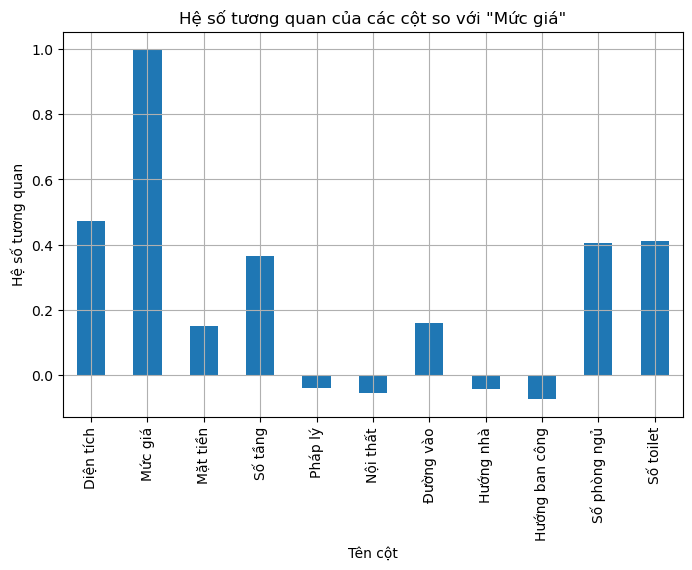

In [14]:
correlations = encode_df.corr()['Mức giá']

plt.figure(figsize=(8, 5))
correlations.plot(kind='bar')

plt.title('Hệ số tương quan của các cột so với "Mức giá"')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Tên cột')
plt.grid(True)
plt.show()

In [15]:
encode_df = encode_df.drop(columns=['Hướng nhà', 'Hướng ban công', 'Pháp lý', 'Nội thất'])
encode_df = encode_df.dropna()
encode_df.to_csv('cleaned_data.csv', index=False)


In [16]:
encode_df.shape

(651, 7)